Train MSE (no drift): 3.226
Test MSE (with drift): 4.356


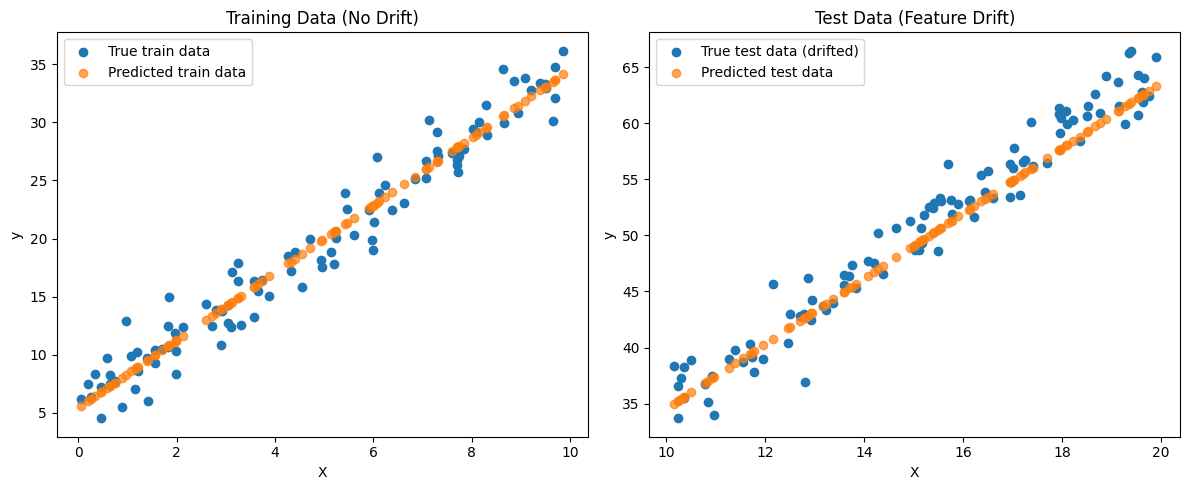

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Create original training data
np.random.seed(42)
X_train = np.random.uniform(0, 10, size=(100, 1))
y_train = 3 * X_train.squeeze() + 5 + np.random.normal(0, 2, 100)  # y = 3x + 5 + noise

# 2. Train Linear Regression model on original data
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Create drifted test data (shifted distribution of X)
X_test = np.random.uniform(10, 20, size=(100, 1))  # Shift feature range from [0-10] to [10-20]
y_test = 3 * X_test.squeeze() + 5 + np.random.normal(0, 2, 100)

# 4. Predict on original training data and drifted test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 5. Compute errors (MSE) on train vs drifted test set
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE (no drift): {mse_train:.3f}")
print(f"Test MSE (with drift): {mse_test:.3f}")

# 6. Plot true vs predicted for both train and drifted test
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_train, y_train, label="True train data")
plt.scatter(X_train, y_train_pred, label="Predicted train data", alpha=0.7)
plt.title("Training Data (No Drift)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_test, y_test, label="True test data (drifted)")
plt.scatter(X_test, y_test_pred, label="Predicted test data", alpha=0.7)
plt.title("Test Data (Feature Drift)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd

# Create original and drifted data (1 feature)
np.random.seed(42)
original_data = np.random.normal(loc=50, scale=5, size=1000)  # mean=50, std=5
drifted_data = np.random.normal(loc=60, scale=7, size=1000)   # mean shifted to 60, std increased to 7

# 1. Calculate statistics
stats_original = {
    "mean": np.mean(original_data),
    "std": np.std(original_data),
}
stats_drifted = {
    "mean": np.mean(drifted_data),
    "std": np.std(drifted_data),
}

# 2. Compare statistics
mean_diff = abs(stats_original["mean"] - stats_drifted["mean"])
std_diff = abs(stats_original["std"] - stats_drifted["std"])

print(f"Original Mean: {stats_original['mean']:.2f}, Drifted Mean: {stats_drifted['mean']:.2f}, Difference: {mean_diff:.2f}")
print(f"Original Std: {stats_original['std']:.2f}, Drifted Std: {stats_drifted['std']:.2f}, Difference: {std_diff:.2f}")

# 3. Set thresholds to detect significant drift
mean_threshold = 3  # example threshold for mean change
std_threshold = 2   # example threshold for std change

mean_drift = mean_diff > mean_threshold
std_drift = std_diff > std_threshold

if mean_drift or std_drift:
    print("Significant data drift detected:")
    if mean_drift:
        print(f"- Mean drift exceeded threshold ({mean_threshold})")
    if std_drift:
        print(f"- Std deviation drift exceeded threshold ({std_threshold})")
else:
    print("No significant data drift detected.")


Original Mean: 50.10, Drifted Mean: 60.50, Difference: 10.40
Original Std: 4.89, Drifted Std: 6.98, Difference: 2.09
Significant data drift detected:
- Mean drift exceeded threshold (3)
- Std deviation drift exceeded threshold (2)


In [3]:
import pandas as pd

# Sample dataset with potential issues
data = {
    "id": [1, 2, 3, 4, 5],
    "age": [25, 30, -1, 45, 22],          # -1 is invalid age
    "email": ["a@example.com", "b@ex.com", "invalid_email", "d@example.com", None],  # one invalid, one missing
    "join_date": ["2022-01-01", "2022-13-01", "2022-03-15", "2022-04-01", "2022-05-01"]  # invalid month 13
}
df = pd.DataFrame(data)

# 1. Define validation checks as functions
def check_positive_age(df):
    invalid_ages = df[df["age"] <= 0]
    return invalid_ages

def check_email_format(df):
    import re
    email_pattern = r"[^@]+@[^@]+\.[^@]+"
    invalid_emails = df[~df["email"].fillna("").str.match(email_pattern)]
    return invalid_emails

def check_date_format(df):
    invalid_dates = []
    for idx, date_str in df["join_date"].items():
        try:
            pd.to_datetime(date_str, format="%Y-%m-%d", errors='raise')
        except:
            invalid_dates.append((idx, date_str))
    return invalid_dates

# 2. Apply validation
invalid_ages = check_positive_age(df)
invalid_emails = check_email_format(df)
invalid_dates = check_date_format(df)

print("Invalid age entries:")
print(invalid_ages if not invalid_ages.empty else "None")

print("\nInvalid email entries:")
print(invalid_emails if not invalid_emails.empty else "None")

print("\nInvalid date entries (index, value):")
print(invalid_dates if invalid_dates else "None")


Invalid age entries:
   id  age          email   join_date
2   3   -1  invalid_email  2022-03-15

Invalid email entries:
   id  age          email   join_date
2   3   -1  invalid_email  2022-03-15
4   5   22           None  2022-05-01

Invalid date entries (index, value):
[(1, '2022-13-01')]


In [4]:
!pip install great_expectations pandas
import pandas as pd
import great_expectations as ge
from great_expectations.core.batch import BatchRequest

# Sample data
data = {
    "name": ["Alice", "Bob", "Charlie", None],
    "age": [25, 30, None, 40]
}
df = pd.DataFrame(data)

# Create an ephemeral context (no files needed)
context = ge.get_context()

# Add a Pandas datasource if not already there
datasource_name = "my_pandas_datasource"
if datasource_name not in [ds["name"] for ds in context.list_datasources()]:
    context.add_datasource(
        name=datasource_name,
        class_name="Datasource",
        execution_engine={"class_name": "PandasExecutionEngine"},
        data_connectors={
            "default_runtime_data_connector": {
                "class_name": "RuntimeDataConnector",
                "batch_identifiers": ["default_identifier_name"],
            }
        },
    )

# Create batch request with our dataframe
batch_request = BatchRequest(
    datasource_name=datasource_name,
    data_connector_name="default_runtime_data_connector",
    data_asset_name="default_data_asset",
    runtime_parameters={"batch_data": df},
    batch_identifiers={"default_identifier_name": "default_id"},
)

# Create or get expectation suite..
expectation_suite_name = "test_suite"
try:
    suite = context.get_expectation_suite(expectation_suite_name)
except ge.exceptions.DataContextError:
    suite = context.create_expectation_suite(expectation_suite_name)

# Create Validator
validator = context.get_validator(
    batch_request=batch_request,
    expectation_suite_name=expectation_suite_name,
)

# Add expectation: 'age' should not have nulls
validator.expect_column_values_to_not_be_null("age")

# Validate and print results
results = validator.validate()
print(results)

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


DataContextError: Datasource is not a FluentDatasource

In [ ]:
import pandas as pd

# Sample datasets
employees_data = {
    "employee_id": [1, 2, 3, 4, 5],
    "department_id": [101, 102, 103, 104, 105],
    "name": ["Alice", "Bob", "Charlie", "David", "Eve"]
}
departments_data = {
    "department_id": [101, 102, 103, 104],
    "department_name": ["HR", "Finance", "IT", "Marketing"]
}

employees_df = pd.DataFrame(employees_data)
departments_df = pd.DataFrame(departments_data)

# 1. Primary Key Check for employees_df (employee_id must be unique and non-null)
def check_primary_key(df, column):
    unique_count = df[column].nunique()
    total_count = len(df[column])
    has_nulls = df[column].isnull().any()
    return unique_count == total_count and not has_nulls

print("Employees employee_id primary key valid:", check_primary_key(employees_df, "employee_id"))

# 2. Foreign Key Check (department_id in employees_df must exist in departments_df)
def check_foreign_key(child_df, child_col, parent_df, parent_col):
    unmatched = child_df[~child_df[child_col].isin(parent_df[parent_col])]
    return unmatched.empty, unmatched

fk_valid, unmatched_rows = check_foreign_key(employees_df, "department_id", departments_df, "department_id")
print("Foreign key valid:", fk_valid)
if not fk_valid:
    print("Rows with invalid foreign keys:")
    print(unmatched_rows)


Employees employee_id primary key valid: True
Foreign key valid: False
Rows with invalid foreign keys:
   employee_id  department_id name
4            5            105  Eve


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Generate example original and drifted data
np.random.seed(42)
original_data = np.random.normal(loc=50, scale=5, size=1000)
drifted_data = np.random.normal(loc=55, scale=5, size=1000)  # Mean shifted to simulate drift

# Perform Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(original_data, drifted_data)

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference detected: Data drift likely present.")
else:
    print("No significant difference detected: Data drift unlikely.")


KS Statistic: 0.429
P-value: 5.819782449389142e-83
Significant difference detected: Data drift likely present.
